<a href="https://colab.research.google.com/github/Gus-1003/ISD-invention-LFP-Analyses/blob/main/exp27/analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando Pacotes:

In [ ]:
!pip install spikeextractors
!pip install neo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/174.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 11.7 MB/s eta 0:00:00


# Importando Bibliotecas:

In [ ]:
from pathlib import Path

import neo
import spikeextractors as se
import re

import scipy.signal as signal
from scipy.signal import butter, filtfilt
from scipy.signal import welch, spectrogram, coherence, firwin, lfilter, filtfilt
from scipy.signal import hilbert

from numpy.fft import fft, ifft, rfft, fftfreq
import seaborn as sns
import scipy.fftpack

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.io import loadmat as ld

# Conectando ao Drive:

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

%cd /content/drive/MyDrive/

Mounted at /content/drive/
/content/drive/MyDrive


# Funções:

In [ ]:
def black_rock_to_df(file_path, nsx=2):
  file_path = Path(file_path)

  if file_path.is_file():

    # Choose Blackrock extension (ns*) to be used
    nsx_to_load = nsx

    # Create recording extractor
    rec = se.BlackrockRecordingExtractor(filename = str(file_path), nsx_to_load=nsx_to_load)

    print(f"Num channels: {rec.get_num_channels()}")
    print(f"Sampling rate: {rec.get_sampling_frequency()}")
    print(f"Duration (s): {rec.get_num_frames() / (rec.get_sampling_frequency())}")
    print(f"Duration (m): {rec.get_num_frames() / (rec.get_sampling_frequency()*60)}")

    ch_names = ['ch '+ str(i) for i in range (1,33) ]
    ch_names.extend(['acc_z','acc_x','acc_y', 'null','gyr_z','gyr_x','gyr_y' ])

    df = pd.DataFrame(rec.get_traces().T, columns = ch_names)
    df = df.drop(columns = ['null'] )

    fs = rec.get_sampling_frequency()
    time = np.linspace(0,len(df)/fs,len(df))

    df['time'] = time

    return fs, df

def basspass(data, cutfreq, filtorder, sampling_rate):

  fny = sampling_rate/2

  b, a = signal.butter(N = filtorder, Wn=np.array(cutfreq) / fny, btype='bandpass')

  dataout = signal.filtfilt(b, a, data)

  return dataout

def wvfilt(lfp,mfreq,sr=1250., w=5, s=1, normwv=True):

        # computing the length of the wavelet for the desired frequency
        wavelen = int(np.round(2*w*s*sr/mfreq))

        # constructs morlet wavelet with given parameters
        wave = signal.morlet(wavelen,w=w,s=s,complete=True)

        # cutting borders
        cumulativeEnvelope = np.cumsum(np.abs(wave))/np.sum(np.abs(wave))
        Cut1 = next(i for (i,val) in enumerate(cumulativeEnvelope[::-1]) if val<=(1./2000))
        Cut2 = Cut1
        Cut1 = len(cumulativeEnvelope)-Cut1-1
        wave = wave[range(Cut1,Cut2)]

        # normalizes wavelet energy
        if normwv:
                wave = wave/(.5*sum(abs(wave)))

        if (len(wave))>len(lfp):
                print('ERROR: input signal needs at least '+str(len(wave))+\
                                                            ' time points for '+str(mfreq)+\
                                                                      'Hz-wavelet convolution')
                return None

        # convolving signal with wavelet
        fsignal = np.convolve(lfp,wave,'same')
        return fsignal


def wvSpect(lfp,freqs,sampling_rate):

        freqs = np.array(freqs).reshape(-1,1)
        tfr = np.zeros((np.size(freqs),len(lfp)),dtype=complex)
        for (fi,f) in enumerate(freqs):
                f = float(f)
                tfr[fi,:] = wvfilt(lfp,f,sampling_rate)

        output = np.abs(tfr).squeeze()

        return output

In [ ]:
def plotAnimatedLFP(time_vector, LFP, startT=0., windowT=5., lfpshift=1000., winshift=.5, srate=1e3, delay=0.25):

    '''This function generates an animated plot of Local Field Potentials (LFP) over
    time. It uses Matplotlib for plotting and IPython's display module for updating
    the plot in a Jupyter Notebook or a similar environment. Specifically, it uses a
    loop to update and display the plot at different time intervals, creating the
    appearance of an animation. The animation includes either a single-channel LFP
    plot or multiple channels with vertical offsets ('lfpshift') between them. The
    delay between updates is controlled by the 'delay' parameter.

    Parameters
    ----------
    time_vector : ndarray
        Time vector.
    LFP : ndarray
        Local field potential signals.
    startT : float
        Preview start time (in seconds). Default is zero.
    windowT : float
        Length of the time window (in seconds). Default is 5 seconds.
    lfpshift : float
        Vertical spacing between each LFP trace (in µV). Default is 1000 µV (1 mV).
    winshift : float
        Time shift between each window update (in seconds).
    srate : float
        Sampling rate (in Hz).
    delay : float
        The delay between plot updates (in seconds).
    '''
    import numpy as np
    import matplotlib.pyplot as plt
    import pylab as pl
    from IPython import display
    import time

    # Time window size (number of samples)
    windowID = int(windowT*srate)

    # Check if LFP is one-dimensional (single channel) or two-dimensional (multiple channels)
    if len(np.squeeze(LFP).shape) == 1:

        while startT < (time_vector[-1] - windowT):
            startID = int(startT*srate) # start time index
            pl.clf() # clear screen
            plt.plot(time_vector[startID:startID+windowID],
                     LFP[startID:startID+windowID],'k',linewidth=.75)
            plt.autoscale(enable=True, axis='x', tight=True)
            plt.ylim(np.min(LFP),np.max(LFP))
            plt.xticks(np.linspace(startT,startT+windowT,9),size=15)
            plt.yticks(size=15)
            plt.ylabel('Amplitude (mV)',size=12);
            plt.xlabel('Time (s)',size=12);

            startT += 0.5
            display.display(pl.gcf());
            time.sleep(delay) # delay execution (in seconds)
            display.clear_output(wait=True)
            plt.tight_layout();

    else:
        nCh         = len(LFP)                                         # number of channels
        yticklabels = [('ch '+str(digit)) for digit in np.arange(nCh)] # channel labels

        while startT < (time_vector[-1] - windowT):
            startID = int(startT*srate) # start time index
            pl.clf() # clear screen
            for ch in range(nCh):
                plt.plot(time_vector[startID:startID+windowID],
                         LFP[ch,startID:startID+windowID]-lfpshift*ch,'k',linewidth=.75)
            plt.autoscale(enable=True, axis='x', tight=True)
            plt.autoscale(enable=True, axis='y', tight=True)
            plt.xticks(np.linspace(startT,startT+windowT,9),size=12)
            plt.yticks(np.linspace(0,-lfpshift*ch,nCh),yticklabels,size=12)
            plt.xlabel('Time (s)',size=12);

            startT += winshift
            display.display(pl.gcf());
            time.sleep(delay) # delay execution (in seconds)
            display.clear_output(wait=True)
            plt.tight_layout();

# Inicio do Processo:

## Leitura do caminho:

In [ ]:
sampling_rate, data = black_rock_to_df('/content/drive/MyDrive/Lab eletrofisio ISD/Projeto Novidade Contextual/Exp27/Exp27 - Registro/Dia01/CCM167/contexto_cinza-20min/20231106-123641/20231106-123641-001.ns2')

Num channels: 39
Sampling rate: 1000.0
Duration (s): 1200.01
Duration (m): 20.000166666666665


# Análise Exploratória (Dados Brutos):

In [ ]:
data.head()

,ch 1,ch 2,ch 3,ch 4,ch 5,ch 6,ch 7,ch 8,ch 9,ch 10,...,ch 30,ch 31,ch 32,acc_z,acc_x,acc_y,gyr_z,gyr_x,gyr_y,time
0,-98.75,-63.00,-112.25,-58.00,-95.25,-93.00,-1.00,40.00,-36.75,-16.50,...,-49.75,-48.75,-30.25,-186.5,-360.0,-557.00,-210.50,-222.25,357.50,0.000
1,-133.25,-92.25,-130.75,-137.00,-177.25,-175.50,-62.50,-6.75,-67.00,-38.75,...,-16.50,-91.50,-64.50,-186.5,-230.0,-534.00,-275.50,-222.25,357.50,0.001
2,-129.00,-73.50,-110.75,-148.50,-211.50,-199.25,-70.50,5.50,-43.75,-31.00,...,-35.25,-132.50,-101.25,-272.5,-230.0,-533.75,-275.50,-212.75,319.25,0.002
3,-166.25,-106.75,-131.75,-215.00,-288.25,-267.25,-120.75,-32.50,-98.25,-57.25,...,-60.00,-159.75,-132.75,-272.5,-108.0,-496.75,-335.25,-212.75,319.00,0.003
4,-144.75,-107.50,-173.00,-200.25,-310.50,-274.75,-126.00,-35.75,-88.50,-51.75,...,-91.25,-140.00,-108.50,-266.5,-108.0,-496.75,-335.00,-219.25,187.25,0.004


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200010 entries, 0 to 1200009
Data columns (total 39 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   ch 1    1200010 non-null  float32
 1   ch 2    1200010 non-null  float32
 2   ch 3    1200010 non-null  float32
 3   ch 4    1200010 non-null  float32
 4   ch 5    1200010 non-null  float32
 5   ch 6    1200010 non-null  float32
 6   ch 7    1200010 non-null  float32
 7   ch 8    1200010 non-null  float32
 8   ch 9    1200010 non-null  float32
 9   ch 10   1200010 non-null  float32
 10  ch 11   1200010 non-null  float32
 11  ch 12   1200010 non-null  float32
 12  ch 13   1200010 non-null  float32
 13  ch 14   1200010 non-null  float32
 14  ch 15   1200010 non-null  float32
 15  ch 16   1200010 non-null  float32
 16  ch 17   1200010 non-null  float32
 17  ch 18   1200010 non-null  float32
 18  ch 19   1200010 non-null  float32
 19  ch 20   1200010 non-null  float32
 20  ch 21   1200010 non-null

## Visualização Gráfica:

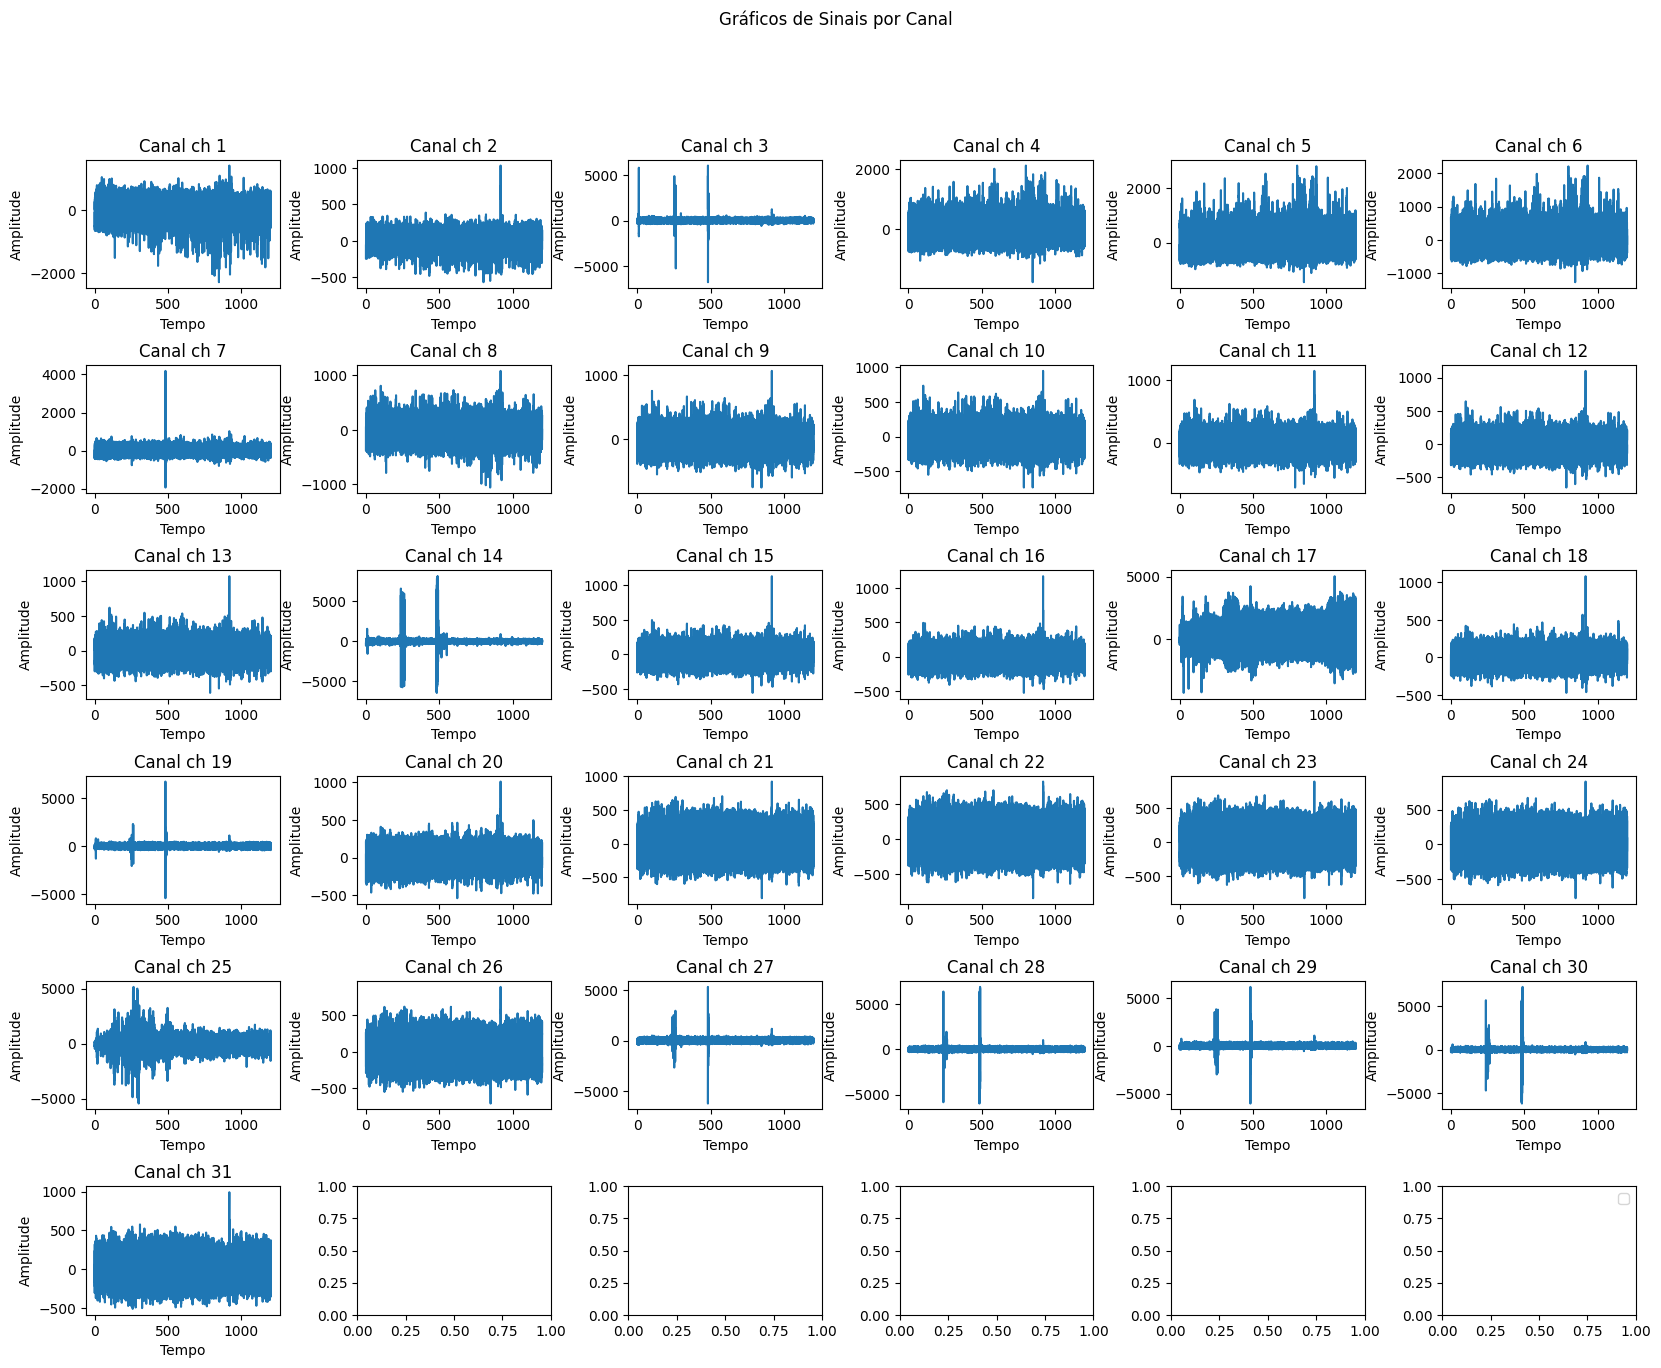

In [ ]:
# Lista de canais
canais = [f'ch {i}' for i in range(1, 32)]

# Configuração do layout de subplots
linhas = 6
colunas = 6

# Criar uma figura e os subplots
fig, axs = plt.subplots(linhas, colunas, figsize=(20, 15))

# Ajustar o layout
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Iterar sobre os canais e criar subplots
for i, canal in enumerate(canais):
    # Calcular a posição do subplot
    linha = i // colunas
    coluna = i % colunas

    # Plotar o sinal do canal
    axs[linha, coluna].plot(data['time'], data[canal], label=canal)
    axs[linha, coluna].set_title(f'Canal {canal}')
    axs[linha, coluna].set_xlabel('Tempo')
    axs[linha, coluna].set_ylabel('Amplitude')

# Adicionar legendas e título
plt.legend()
plt.suptitle('Gráficos de Sinais por Canal')
plt.show()

In [ ]:
# LFP
LFP = data.iloc[:,:32].values.T
print(LFP.shape)

# Time vector
time_vector = data['time'].values
print(time_vector.shape)

(32, 1200010)
(1200010,)


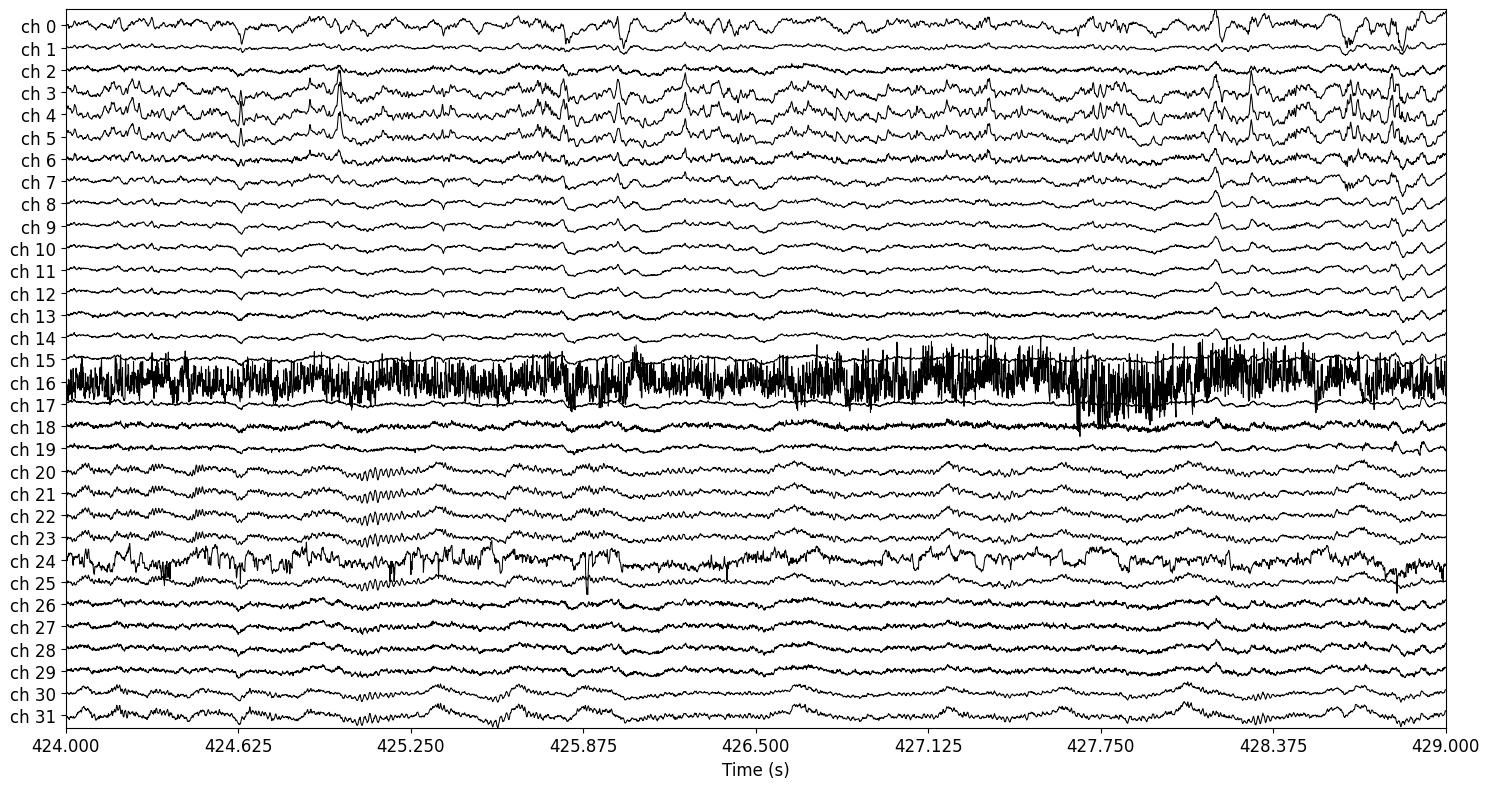

KeyboardInterrupt: 

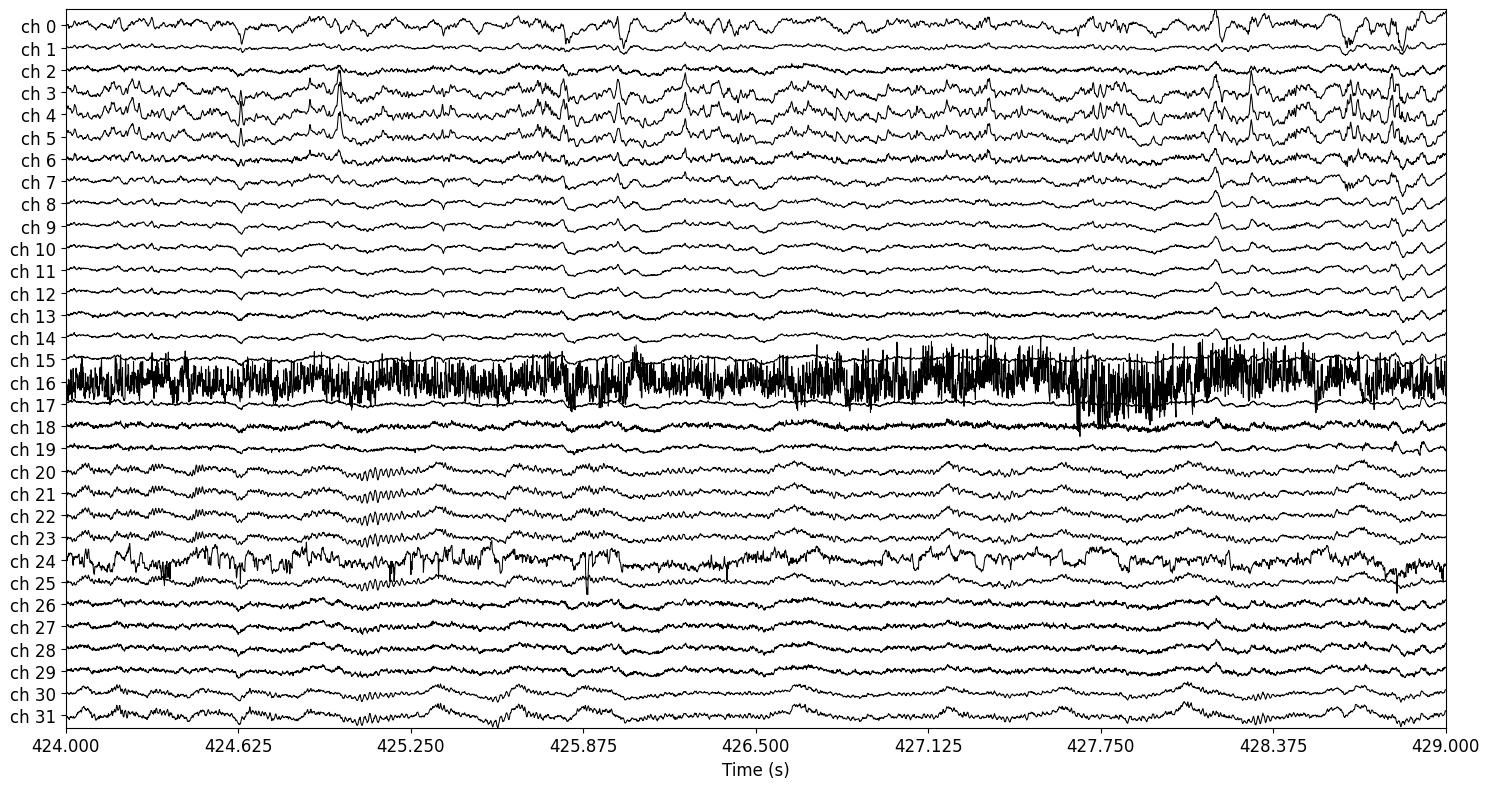

In [ ]:
plt.figure(figsize=(15,8))
plotAnimatedLFP(time_vector, LFP)

In [ ]:
duration = 1200.01
ch = "ch 10"

In [ ]:
sinal = data[ch]

plt.figure(figsize=(20,5))

plt.plot(sinal)

## Pré-Processamento:

In [ ]:
min_idx = int(sampling_rate * 80)
max_idx = int(sampling_rate * 120)
janela = sinal.iloc[min_idx:max_idx]

# Plot de uma janela de tempo do sinal presente no canal ch - de tal segundo a tal segundo
plt.figure(figsize=(20,5))

plt.plot(janela)

In [ ]:
# Calcular a FFT
fft_result = np.fft.fft(janela)
frequencias = np.fft.fftfreq(len(janela), d=1)  # d é o intervalo entre as amostras

# Configurar a figura e os subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Subplot 1: Plotar a FFT
axs[0].plot(frequencias, np.abs(fft_result), label='FFT do Sinal', color='blue')
axs[0].set_title('Análise de Frequência')
axs[0].set_xlabel('Frequência (Hz)')
axs[0].set_ylabel('Magnitude')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Plotar a metade dos valores
fft_abs = abs(fft_result)
metade = len(fft_abs) // 2
axs[1].plot(frequencias[:metade], fft_abs[:metade], label='Metade dos Valores', color='orange')
axs[1].set_title('Metade dos Valores da FFT')
axs[1].set_xlabel('Frequência (Hz)')
axs[1].set_ylabel('Magnitude')
axs[1].legend()
axs[1].grid(True)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [ ]:
# Definir a faixa de frequência desejada
freq_range = (0, 100)

# Calcular o espectrograma
frequencies, times, Sxx = spectrogram(sinal, fs=sampling_rate, nperseg=150, noverlap=128)

# Encontrar índices correspondentes à faixa de frequência desejada
freq_idx = np.where((frequencies >= freq_range[0]) & (frequencies <= freq_range[1]))[0]

# Plotar o espectrograma
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies[freq_idx], 10 * np.log10(Sxx[freq_idx, :]), cmap='viridis')
plt.title('Espectrograma (0-50Hz)')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.colorbar(label='Intensidade (dB)')

# Adicionar grade e melhorar a legibilidade
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff[0], cutoff[1], fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Seleciona um canal especifico
channel = data[ch]

### Segementação da Faixa de Sinal de Interesse:

In [ ]:
# Define as frequências de corte para a banda de frequência theta
theta_fcut = [5, 10]

# Definição das frequências de corte para a banda gamma
gamma_fcut = [30, 60]

# Definição da frequência máxima para a banda theta
theta_maxf = 12

# Taxa de amostragem mínima (frequência de Nyquist) para representar adequadamente um sinal
fny = sampling_rate/2

# Normalização do sinal
channel_normalized = (channel - np.mean(channel)) / np.std(channel)

# Filtragem do sinal
b_high, a_high = signal.butter(N=8, Wn=theta_fcut[0] / fny, btype='high')
lfp_f_high = signal.filtfilt(b_high, a_high, channel_normalized)

b_low, a_low = signal.butter(N=8, Wn=theta_fcut[1] / fny, btype='low')
lfp_f_low = signal.filtfilt(b_low, a_low, lfp_f_high)

lfp_f2 = basspass(channel_normalized, theta_fcut, 4, sampling_rate)

# Aplicação de um filtro passa-baixa (função basspass) na variável 'channel' com as frequências de corte para a banda theta
# O parâmetro '4' representa a ordem do filtro
# O parâmetro 'sampling_rate' representa a taxa de amostragem
theta = basspass(channel, theta_fcut, 4, sampling_rate)

# Aplicação de um filtro passa-baixa (função basspass) na variável 'channel' com as frequências de corte para a banda gamma
gamma = basspass(channel, gamma_fcut, 4, sampling_rate)

### Encontrando os Picos de Theta:

In [ ]:
# Encontrar os picos na variável 'theta' usando a função find_peaks do módulo 'signal'
# A altura dos picos é configurada como 0 e a distância entre os picos é baseada na taxa de amostragem e na frequência máxima da banda theta
theta_peaks = signal.find_peaks(theta, height=0, distance=int(sampling_rate/theta_maxf))[0]

### Plot PSD - Análise de Potência Espectral

In [ ]:
# Análise de Potência Espectral (PSD)
nperseg = sampling_rate * 1
noverlap = nperseg // 2

psd_frqs, psd = signal.welch(channel_normalized, fs=sampling_rate, nperseg=nperseg, noverlap=noverlap, nfft=nperseg)

psd_frqs, psd_f = signal.welch(lfp_f_high, fs=sampling_rate, nperseg=nperseg, noverlap=noverlap, nfft=nperseg)

psd_frqs, psd_f2 = signal.welch(lfp_f2, fs=sampling_rate, nperseg=nperseg, noverlap=noverlap, nfft=nperseg)

# Plotagem dos Resultados
plt.figure(figsize=(10, 6))
plt.plot(psd_frqs, psd, color='k', lw=3, label='Original')
plt.plot(psd_frqs, psd_f, color='m', lw=4, label='Filtro passa-alta e passa-baixa')
plt.plot(psd_frqs, psd_f2, color='r', lw=2, label='Outro filtro')

plt.legend()
plt.xlim(1, 100)
plt.grid(True)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Densidade Espectral de Potência')
plt.title('Análise Espectral do Sinal')
plt.show()

In [ ]:
import pywt

# Especificar a wavelet a ser usada (pode experimentar diferentes)
wavelet = 'cmor'

# Calcular a decomposição da wavelet
coeffs, freqs = pywt.cwt(theta, np.arange(1, 128), wavelet)

# Plotar a decomposição da wavelet
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(coeffs), aspect='auto', extent=[0, len(theta), 1, 128], cmap='jet', interpolation='bilinear')
plt.title('Análise de Wavelet do theta')
plt.xlabel('Amostras')
plt.ylabel('Escala da Wavelet')
plt.colorbar(label='Magnitude')
plt.show()

In [ ]:
# Criação de um array 'smps2plot' representando o intervalo de amostras a serem plotadas
smps2plot = np.arange(int(sampling_rate*5), sampling_rate*6)

# Configuração do tamanho da figura do gráfico
plt.figure(figsize=(25,5))

# Plotagem da variável 'channel' em preto (k)
plt.plot(channel, color='k', lw=2, label='Sinal Original')

# Plotagem da variável 'theta' em vermelho (r)
plt.plot(theta, color='r', lw=2, label='Banda Theta')

# Destaque dos picos de theta no gráfico com marcadores circulares vermelhos
plt.plot(theta_peaks, theta[theta_peaks], lw=0, color='m', marker='o', markersize=10)

# Plotagem da variável 'gamma' em verde escuro (darkgreen)
plt.plot(gamma, color='darkgreen', lw=2, label='Banda Gamma')

# Configuração dos limites do eixo x e y do gráfico
plt.xlim(smps2plot.min(), smps2plot.max())
plt.ylim(-300,300)

# Configurações adicionais do gráfico
plt.title('Análise Temporal de Bandas Theta e Gamma')
plt.xlabel('Amostras Relativas ao Pico Theta')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Definição de variáveis
time_ref = theta_peaks
signal_2trigger = channel
ta_winlen = 400

# Ajuste dos tempos de referência para evitar bordas da janela
time_ref = time_ref[(time_ref > ta_winlen//2) & (time_ref < len(signal_2trigger) - ta_winlen//2)]

# Índice da janela de análise temporal
ta_win_i = 0

# Cálculo de amostras relativas e absolutas
rel_samples = np.arange(ta_winlen) - ta_winlen//2
win_samples = rel_samples + time_ref[ta_win_i]

# Plotagem
plt.figure(figsize=(12, 4))
plt.plot(rel_samples, signal_2trigger[win_samples], label='Sinal Original', color='blue')
plt.plot(rel_samples, theta[win_samples], label='Banda Theta', color='red')
plt.title('Análise Temporal do Sinal Original e da Banda Theta')
plt.xlabel('Amostras Relativas ao Pico Theta')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Aplicação da transformada de Hilbert nas bandas theta e gamma
gamma_hilb = signal.hilbert(gamma)
gamma_env = np.abs(gamma_hilb)

theta_hilb = signal.hilbert(theta)
theta_env = np.abs(theta_hilb)

# Configuração da figura do gráfico
plt.figure(figsize=(25, 5))

# Plotagem dos sinais originais e das envoltórias
plt.plot(channel, color='k', lw=2, label='Sinal Original')
plt.plot(theta, color='r', lw=2, label='Banda Theta')
plt.plot(theta_env, '--', color='r', lw=2, label='Envoltória Theta')
plt.plot(gamma, color='darkgreen', lw=2, label='Banda Gamma')
plt.plot(gamma_env, '--', color='darkgreen', lw=2, label='Envoltória Gamma')

# Destaque dos picos de theta no gráfico com marcadores circulares vermelhos
plt.plot(theta_peaks, theta[theta_peaks], lw=0, color='r', marker='o', markersize=10, label='Picos Theta')

# Configuração dos limites do eixo x e y do gráfico
plt.xlim(smps2plot.min(), smps2plot.max())
plt.ylim(-300, 300)

# Adição de rótulos e legendas
plt.title('Análise das Bandas Theta e Gamma com Envoltórias')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Exibição do gráfico
plt.show()

In [ ]:
def do_ta(time_ref, signal_2trigger, ta_winlen):
    # Ajuste dos tempos de referência para evitar bordas da janela
    time_ref = time_ref[(time_ref > ta_winlen//2) & (time_ref < len(signal_2trigger) - ta_winlen//2)]

    # Criação da matriz de janelas temporais
    ta_mat = np.zeros((len(time_ref), ta_winlen))

    for ta_win_i in range(len(time_ref)):
        rel_samples = np.arange(ta_winlen) - ta_winlen//2
        win_samples = rel_samples + time_ref[ta_win_i]

        # Ajuste para garantir que win_samples esteja dentro dos limites
        win_samples = np.clip(win_samples, 0, len(signal_2trigger) - 1)

        ta_mat[ta_win_i] = signal_2trigger[win_samples]

    # Cálculo da média ao longo das janelas temporais
    ta = np.mean(ta_mat, axis=0)
    return ta

In [ ]:
# Aplicação da função do_ta para os sinais theta e gamma_env
ta_theta = do_ta(theta_peaks, channel, ta_winlen)
ta_gammaenv = do_ta(theta_peaks, gamma_env, ta_winlen)

# Configuração da figura do gráfico
plt.figure(figsize=(10, 6))

# Plotagem dos resultados
plt.subplot(2, 1, 1)
plt.plot(rel_samples, ta_theta, color='k', lw=2)
plt.title('Análise Temporal - Sinal theta')
plt.xlabel('Amostras Relativas ao Pico Theta')
plt.ylabel('Média Temporal')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rel_samples, ta_gammaenv, color='darkgreen', lw=2)
plt.title('Análise Temporal - Envoltória Gamma')
plt.xlabel('Amostras Relativas ao Pico Theta')
plt.ylabel('Média Temporal')
plt.grid(True)

# Ajustes finais
plt.tight_layout()
plt.show()